# 2020-07-06

Working on analyzing Augusto's confocal MS2 data with an eye towards 1) figuring on how to do this and 2) preparing to analyze pol2 and Dorsal data once we get re-spooled.

I've got a halfway-decent initial segmentation routine now. I'm going to table that for a bit and start getting into actually analyzing the traces. Some things that need doing:

1. Visualizing spots (as a check for segmentation and intensity measurements.
2. Connecting spots/nuclei across focus breaks.
3. Getting data in the right format for ease of work (probably worthwhile to get spot data into single dataframes—need to explore Pandas.
4. Triggered averaging (index to features).

In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

In [89]:
# Read in czi file.
stack12 = read_czi('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/EVE_D11-12.czi', True)
stack13 = read_czi('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/EVE_D11-13.czi', True)
stack14 = read_czi('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/data/EVE_D11-14.czi', True)

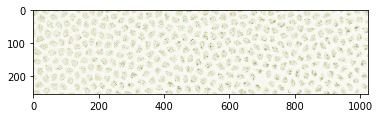

In [19]:
#ax=imp.qax(2)
plt.imshow(stack13[1,-1,0],alpha=0.5,cmap="Reds")
plt.imshow(stack14[1,0,0],alpha=0.5,cmap="Greens")

In [4]:
nucmask = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-12_nucmask.pkl')
spot_data = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-12_spot_data_plus.pkl')

## 1. Visualizing spots

Strategy: Make a viewable stack of spots. It will have a dimension that is the spot ID, and will contain the raw imaging data for a 4D window around the detected spot center. Default will be to view a max Z-projection through time.

In [375]:
############################################################################
def spot_movies(stack, spot_data, channel=0, len_ij=15, len_z=7, view=True):
    """Make image stack for viewing MS2 spot raw data
    
    Given spot coordinates and original movie, builds an image stack with 
    spot ID on the first dimension and raw data centered on the spot in the
    remaining three. Has the slightly strange behavior that if the viewing 
    window will run off the edge of the image, the center of the window is
    "nudged" into the image to avoid this. Spots near the edge may thus be
    displaced from the center.
    
    Args:
        stack: ndarray
            5-D image stack [c,t,z,x,y]
        spot_data: dict of ndarrays
            Data containing tracking of spots detected. Dict entries are unique 
            spot IDs (numeric 1...), rows of ndarray are detections of the spot 
            in a single frame. Required columns: 5: gaussian fit height, 6: 
            gaussian fit z-width, 7: gaussian fit x-width, 8: gaussian fit 
            y-width.
        channel: int
            Channel from which to use data
        len_ij: int
            Length (in pixels) of the box to collect around each spot in the 
            lateral (ij) dimension.
        len_z: int
            Length (in pixels) of the box to collect around each spot in the 
            axial (z) dimension.
        view: bool
            If true, calls viewer function on the resulting stack using a max 
            projection on Z dimension (order spot_ID-t-x-y)
            
    Returns:
        movies: ndarray
            5D image stack of input data centered around each spot. In order 
            [spot_id, t,z,x,y]
    """
    def nudge(x, dimsize, rad):
        """If needed, move center away from image edges to avoid running off."""
        lim = int(dimsize - 1)
        nudged_x = x
        if ((x - rad) < 0):
            nudged_x = rad
        if ((x + rad) > lim):
            nudged_x = lim - rad
        return int(nudged_x)
    # Check that window dimensions are appropriate.
    if ((len_ij % 2 == 0) or (len_z % 2 == 0)):
        raise ValuError('len_ij and len_z must be odd')
    # Define 'radii' for window (distance to go from home pixel in each direction).
    z_rad = int((len_z - 1) / 2)
    ij_rad = int((len_ij - 1) / 2)
    # Initialize movies as a zeros array.
    movies = np.zeros((len(spot_data)+1, stack.shape[1], len_z, len_ij, len_ij))
    # Add data for each spot.
    for spot in spot_data:
        arr = spot_data[spot]
        for row in arr:
            t = int(row[0])
            z,i,j = row[2:5]
            z = nudge(z, stack.shape[-3], z_rad)
            i = nudge(i, stack.shape[-2], ij_rad)
            j = nudge(j, stack.shape[-1], ij_rad)
            frame = stack[channel, t, (z-z_rad):(z+z_rad+1), (i-ij_rad):(i+ij_rad+1), (j-ij_rad):(j+ij_rad+1)]
            movies[spot, t] = frame
    # If viewer call specified, call with max Z-projection.
    if(view):
        viewer(movies.max(axis=2), 'itxy')
    return movies
#viewer(spot_movies(stack, spot_data).max(axis=2))
#viewer(spot_movies(stack, spot_data).max(axis=1))
a=spot_movies(stack, spot_data)

NameError: name 'stack' is not defined

These all seem to be off-center. They seem centered at Z-slice 4 and 6,6 in xy. I think it may be a rounding issue. I used int() to convert the fit coordinates into integer coordinates, which is an aggressive round-down. I tweaked the ms2_fit function to round to nearest int using round() function instead. I re-processed this test movie and load the output here:

In [48]:
spot_data2 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-12_spot_data_plus_updated.pkl')

In [77]:
a=spot_movies(stack, spot_data)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'gray_r', 'plasma', 'gray', 'inf…

In [64]:
spot_data = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-12_spot_data_plus.pkl')

In [68]:
viewer(spot_movies(stack, spot_data, len_ij=21).max(axis=2), 'stxy')

3 10


interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'gray_r', 'plasma', 'gray', 'inf…

This seems to work very well! Hooray! Spots are now cenetered. I could play with the viewer in certain ways, but this is pretty good as is. Moving on to next task:

# 2. Connecting across focus breaks.

Experience shows that, unfortunately, sometimes the focus breaks are not clean and there is some translation in xy. The challenge is to correct this, connecting nuclei and spots across these gaps. I have an idea to use the nuclear masks to derive a positional correction, then use that (perhaps via nuclear mask intermediary or perhaps not) to connect spots.

In [27]:
nucmask12 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-12_nucmask.pkl')
nucmask13 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-13_nucmask.pkl')
nucmask14 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-14_nucmask.pkl')

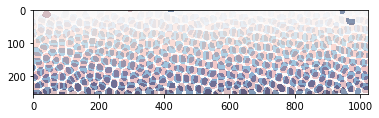

In [82]:
plt.imshow(nucmask13[0,0],alpha=0.5, cmap="Reds")
plt.imshow(nucmask14[0,0],alpha=0.5, cmap="Blues")

In [122]:
a12 = nucmask12[-1]
a13 = nucmask13[-1]
a14 = nucmask14[0]
a1.shape

(21, 256, 1024)

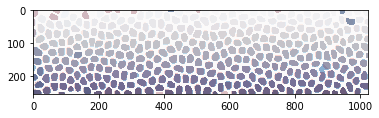

In [123]:
plt.imshow(a13[0],alpha=0.5, cmap="Reds")
plt.imshow(a14[0],alpha=0.5, cmap="Blues")

In [94]:
a3 = ndi.shift(a1, (0,-150,10))

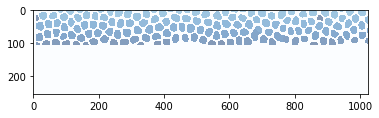

In [95]:
#plt.imshow(a1[0],alpha=0.5, cmap="Reds")
plt.imshow(a3[0],alpha=0.5, cmap="Blues")

In [108]:
ishift_range = 15
jshift_range = 15
mask1 = a1[0].astype('bool')
mask2 = a2[0].astype('bool')

mid_i0 = ishift_range+1
mid_i1 = mask1.shape[0] - ishift_range
mid_j0 = jshift_range+1
mid_j1 = mask1.shape[1] - jshift_range
mask1_middle = mask1[mid_i0:mid_i1, mid_j0:mid_j1]
curr_agree = 0
curr_ishift = 0
curr_jshift = 0
for ishift in range(-ishift_range, ishift_range,1):
    print(ishift)
    for jshift in range(-jshift_range, jshift_range,1):
        mask2_shifted = ndi.shift(mask2, (ishift, jshift))
        mask2_shifted_middle = mask2_shifted[mid_i0:mid_i1, mid_j0:mid_j1]
        agree = np.count_nonzero(mask1_middle == mask2_shifted_middle)
        if (agree > curr_agree):
            curr_agree = agree
            curr_ishift = ishift
            curr_jshift = jshift

-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [111]:
curr_ishift, curr_jshift

(0, -1)

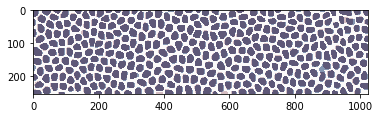

In [113]:
mask3 = ndi.shift(mask2, (curr_ishift,curr_jshift))
#ax = imp.qax(2)
plt.imshow(mask1,alpha=0.5, cmap="Reds")
plt.imshow(mask2,alpha=0.5, cmap="Blues")

In [28]:
stackt = np.vstack((nucmask12, nucmask13, nucmask14))

In [119]:
viewer(stackt)

interactive(children=(Dropdown(description='Color', index=8, options=('Reds', 'gray_r', 'plasma', 'gray', 'inf…

In [121]:
nucmask13.shape

(23, 21, 256, 1024)

## Oh, crap

So it turns out this isn't necessary. There is almost no ij-translation during the Z-focus break. I think I made a mistake previously of comparing the first frame of movie 13 to the first frame of 14, and there is considerable nuclear movements between them. I'm gonna try something here, stacking these stacks again and doing nuclear segmentation.



In [96]:
#stackt = np.vstack((stack12[0], stack13[0], stack14[0]))
stack14.shape

(2, 20, 21, 256, 1024)

In [34]:
# Perform initial segmentation of nuclei.
nucmask_init = imp.segment_nuclei_4dstack(stackt, imp.segment_nuclei3D_monolayer, sigma1=4, min_seed_dist=13, size_max=2000)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


In [35]:
viewer(nucmask_init)

interactive(children=(Dropdown(description='Color', index=5, options=('prism', 'Greens', 'gray_r', 'magma', 'p…

Yeah, there's no translation and no registration problem. Damn. Not sure how that happened. Anyway, I have the code up there if I need to ever work on registration. Learned a little...

OK so I just need to fairly trivially stitch nuclear masks and spot data together over the focus break. 

I think I'll stitch the existing data structures together so all I have to do is update the nuclear mask and the list of spots, then I'll unpack that a bit into some convenient-to-work-with data structures.

In [77]:
nucmask12 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-12_nucmask.pkl')
nucmask13 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-13_nucmask.pkl')
nucmask14 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-14_nucmask.pkl')
spot_data12 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-12_spot_data_plus.pkl')
spot_data13 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-13_spot_data_plus.pkl')
spot_data14 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-14_spot_data_plus.pkl')





In [4]:
class movie():
    # Class attributes    
    # Initializer
    def __init__(self, nucmask, spot_data):
        self.nucmask = nucmask
        self.spot_data = spot_data

In [78]:
mv12 = movie(nucmask12, spot_data12)
mv13 = movie(nucmask13, spot_data13)

In [74]:
mv13.spot_data[2]

array([[0.00000000e+00, 4.10000000e+01, 0.00000000e+00, 2.00000000e+01,
        2.54000000e+02, 6.23816249e+04, 7.86988402e-01, 9.81502294e-01,
        1.05527028e+00, 1.17224706e+04, 5.22134168e+03],
       [1.00000000e+00, 4.10000000e+01, 0.00000000e+00, 1.80000000e+01,
        2.55000000e+02, 4.09653911e+03, 7.02034845e+00, 5.06443936e+00,
        5.93242973e+00, 6.62492157e+03, 3.56813347e+03],
       [2.00000000e+00, 4.10000000e+01, 0.00000000e+00, 1.80000000e+01,
        2.57000000e+02, 5.79091177e+03, 5.40731375e+00, 3.97795978e+00,
        4.07983815e+00, 9.14574510e+03, 4.52484605e+03],
       [3.00000000e+00, 4.10000000e+01, 0.00000000e+00, 1.80000000e+01,
        2.57000000e+02, 7.16380839e+03, 4.75131637e+00, 3.61024430e+00,
        3.63182753e+00, 9.79290196e+03, 5.29269236e+03],
       [4.00000000e+00, 4.10000000e+01, 0.00000000e+00, 1.90000000e+01,
        2.58000000e+02, 3.39589734e+04, 1.57985784e+00, 1.21912425e+00,
        1.64042792e+00, 1.23360392e+04, 7.39982771e+

In [125]:
from imagep import update_labels, sortfreq
############################################################################
def stitch_ms2(mv1, mv2):
    """Stitch two MS2 movies together across a focus break
    
    Connect two confocal MS2 movies together that are separated by a 
    re-focusing break. First connects nuclear masks, then connects spots
    based on nuclear ID (spots in the same nucleus are connected).
    
    Args:
        mv1: movie object
            First object of movie class with nucmask and spot_data features
        mv2: movie object
            Second object of movie class. Nucleus and spot IDs will be updated
            to match those of mv1
    
    Returns:
        mv_stitched: movie object
            Movie object with nucmask and spot_data from mv1 and mv2 stitched
            together
    """
    
    def update_nucleus_id(data, mask):
        """Update the nuclear ID field of a spot data array based on spot 
        coordinates and updated nuclear mask."""
        for i in range(0, data.shape[0]):
            coords = tuple([int(data[i,0]), int(data[i,2]), int(data[i,3]), 
                int(data[i,4])])
            nuc = mask[coords]
            data[i,1] = nuc
            
    def link_nuc_spots(data):
        """Link nuclei to spots. Make dictionary with nucleus ID as key and 
        spot ID as value."""
        links = {}
        for spot in data:
            # Find modal nuclear ID for the spot.
            nucs = sortfreq(data[spot][:,1])
            if (nucs[0] != 0):
                nuc_id = int(nucs[0])
                if (nuc_id not in links):
                    links[nuc_id] = spot
                # If nuc already has a spot, select spot with longest trajectory.
                else:
                    curr_spot_id = links[nuc_id]
                    len_curr_spot = len(data[curr_spot_id][:,1])
                    len_this_spot = len(data[spot][:,1])
                    if (len_this_spot > len_curr_spot):
                        links[nuc_id] = int(spot)
        return links
    
    # Main.
    
    ### Connect nuclear masks ###
    
    # Merge last two frames of mv1 and first two frames of mv2 to account for 
    # potential dropout.
    end1 = mv1.nucmask[-2:].max(axis=0)
    start2 = mv2.nucmask[0:2].max(axis=0)
    # Update labels from mv2 to match those of mv1
    updated_mask2 = update_labels(end1, start2)
    
    # Generate an update table for old (mv2) to new (mv1) nuc IDs
    convert = {}
    for old in np.unique(start2)[1:]:
        new = np.unique(updated_mask2[start2 == old])[0]
        if (new != 0):
            convert[old] = int(new)

    # Update nucmask of mv2 with new labels, stitch mv1 and mv2 masks together.
    labels = list(np.unique(mv1.nucmask))
    newmask = np.zeros_like(mv2.nucmask)
    for old in np.unique(mv2.nucmask)[1:]:
        if (old in convert):
            newmask[mv2.nucmask == old] = convert[old]
        else:
            new_id = max(labels) + 1
            newmask[mv2.nucmask == old] = new_id
            labels.append(new_id)
    nucmask_stitched = np.vstack((mv1.nucmask, newmask))
    
    ### Connect spot_data ###
    
    # Make dict of nucleus-spot connections in mv1.
    mv1_nuc_spot_links = link_nuc_spots(mv1.spot_data)
    # Get t (frame) number to adjust by.
    t_adjust = mv1.nucmask.shape[0]
    # Initialize stitched data with mv1 data.
    spot_data_stitched = mv1.spot_data.copy()
    # Keep track of spot_ids used.
    spot_ids = list(mv1.spot_data.keys())
    
    # For each spot in mv2, either connect to a spot in mv1 or initialize as new spot.
    for spot in mv2.spot_data:
        data = np.copy(mv2.spot_data[spot])
        # Update time.
        data[:,0] = data[:,0] + t_adjust
        # Update nucleus ID using new mask (in place).
        update_nucleus_id(data, nucmask_stitched)
        # Get modal nucleus.
        nucs = sortfreq(data[:,1])
        nuc_id = int(nucs[0])
        # If linked to an mv1 spot, merge data for spot.
        if nuc_id in mv1_nuc_spot_links:
            linked_spot_id = mv1_nuc_spot_links[nuc_id]
            spot_data_stitched[linked_spot_id] = np.vstack((mv1.spot_data[linked_spot_id], data))
        # If unlinked, make a new spot.
        else:
            new_spot_id = max(spot_ids) + 1
            spot_data_stitched[new_spot_id] = data
            spot_ids.append(new_spot_id)
    
    stack_stitched = np.vstack()
    mv_stitched = movie(nucmask_stitched, spot_data_stitched)
    return mv_stitched
mv_stitch =stitch_ms2(mv12, mv13)

<class '__main__.movie'>


In [126]:
stackt = np.vstack((stack12[0], stack13[0]))
stackt = np.expand_dims(stackt, 0)
imp.quickview_ms2(stackt, mv_stitch.spot_data)
stackt.shape

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'cividis', 'plasma', 'gray_r'…

(1, 38, 21, 256, 1024)

Committed __stitch_ms2__ and __movie__ class to imagep.py. Testing:

In [128]:
reload(imp)
mv_stitch2 = imp.stitch_ms2(mv12, mv13)

In [129]:
imp.quickview_ms2(stackt, mv_stitch2.spot_data)

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'cividis', 'plasma', 'gray_r'…

# 3. Building a better data structure for movie class

What would be useful to have? Probably a convenient panda dataframe structure. Don't really understand pandas so...prob take a break to learn something.

OK I just looked at a couple things from Panda home. Basically these are R dataframes, which is cool. However it isn't obvious that I exactly need such a thing right now. But...it is a fine way to make a 2D table so I'll go ahead and shoot for it for my integrated volume and integrated fit tables.

In [156]:
import pandas as pd
def make_spot_table(spot_data, colnum, nframes):
    data = {}
    for spot in spot_data:
        arr = spot_data[spot]
        vals = np.zeros(nframes)
        for i in range(0, len(arr)):
            t = int(arr[i,0])
            val = arr[i,colnum]
            vals[t] = val
        data[spot] = vals
    return pd.DataFrame(data)

In [173]:
t=make_spot_table(mv12.spot_data, 11, 15)

IndexError: index 11 is out of bounds for axis 1 with size 11

In [184]:
reload(imp)
test = imp.movie(mv12.nucmask, mv12.spot_data)

In [186]:
test.intfit

,1,2,3,4,5,6,7,8,9,10,...,167,168,169,170,171,172,173,174,175,176
0,5843.637553,2161.507182,3335.428391,3134.918612,6587.815538,2717.907036,5164.153348,4388.720974,2373.200508,3893.944998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5849.742180,2166.516155,4567.091092,3399.594347,7262.881565,2804.355735,4050.550705,3996.986570,2221.884661,4884.858489,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5801.947703,2106.228661,5731.071167,3096.540614,8499.611410,2962.851796,4305.652317,4911.642890,2171.621570,3115.769210,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4692.596543,2056.518720,6354.934453,2677.397116,7663.597082,2849.261058,3970.257923,5556.006195,2071.997535,3944.893320,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2768.389114,1949.364233,6176.454574,2906.579148,6064.570559,2998.330077,3644.057484,5516.835302,1977.531012,3652.381825,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,6287.832563,2041.632126,5885.380050,2637.868954,6733.837897,3289.505986,3166.840330,4379.152734,1976.183708,3289.421898,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,3675.670772,0.000000,7561.664015,2873.665160,6247.867188,3173.453569,2712.014149,6858.813524,2051.764449,3491.350082,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,3858.797920,0.000000,0.000000,2620.534138,4620.996331,3049.771140,2507.705115,6206.858284,2102.427249,3379.258690,...,1787.543146,1913.083602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,7346.692174,0.000000,6155.697558,2464.817547,4024.992927,2902.054270,2314.315928,6011.088779,2457.993467,3209.064680,...,1979.526786,1937.767629,1868.130814,1809.057301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,6690.106294,0.000000,5477.355574,2439.732009,4129.660387,2997.492304,2254.533996,6611.359547,2500.963380,2989.906301,...,1932.347159,1866.933644,1896.632006,2061.373820,4134.235626,1817.618775,1911.246527,0.000000,0.000000,0.000000


This works. Cool. I need to update the stitch function to accomodate the expanded movie class.

In [189]:
mv12 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-12_mv.pkl')
mv13 = load_pickle('/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/results/EVE_D11-13_mv.pkl')

In [190]:
# Fits can be joined by simple concatenation
testlist = mv12.fits + mv13.fits

In [193]:
len(mv13.fits)

23

In [195]:
mv13.stack.shape

(2, 23, 21, 256, 1024)

In [214]:
mv1 = mv12
mv2 = mv13
def stitch_stacks(stack1, stack2):
    stack_stitched = np.vstack((stack1[0], stack2[0]))
    for i in range(1, stack1.shape[0]):
        channel_stitched = np.vstack((stack1[i], stack2[i]))
        stack_stitched = np.stack((stack_stitched, channel_stitched))
    return stack_stitched
stack_stitched = stitch_stacks(mv1.stack, mv2.stack)

In [215]:
viewer(stack_stitched)

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'cividis', 'plasma', 'gray_r'…

In [216]:
reload(imp)

<module 'imagep' from '/Users/MStadler/Bioinformatics/Projects/Zelda/Quarantine_analysis/bin/imagep.py'>

In [217]:
stitch = imp.stitch_ms2(mv12, mv13)

In [220]:
len(stitch.fits)

38

In [223]:
imp.quickview_ms2(stitch.stack, stitch.spot_data)

interactive(children=(Dropdown(description='Color', index=4, options=('inferno', 'cividis', 'plasma', 'gray_r'…

In [222]:
?imp.quickview_ms2

In [226]:
a = np.empty(10)
a.fill(np.nan)
a

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [227]:
reload(imp)
s2 = imp.movie(stitch.stack, stitch.nucmask, stitch.fits, stitch.spot_data)

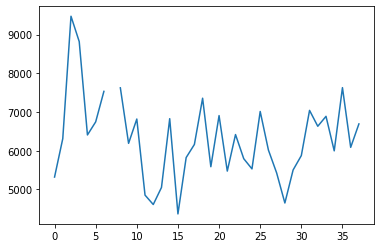

In [235]:
s2.prot[3].plot()

### 4. Triggered averaging

Need to write a function to do triggered averaging. I think it should take a panda dataframe (one of the members of a movie object) and a dict with spot_ID as keys and frame numbers as values. Also needs to take a window size and a term for what to do with nan (including for cases where averaging window extends past edges).

It won't do averaging, actually just build an ndarray wiht the aligned traces. Maybe it'll also return the mean...

In [373]:
############################################################################
def align_traces(df, locs, window_size=11, include_nan=True):
    """Align MS2 traces around selected frames
    
    For use in triggered averaging. Takes a dataframe of trace data and a 
    list of spot IDs and frame numbers, makes a panda dataframe of the trace
    data centered on the indicated frames.
    
    Args:
        df: pandas dataframe
            Trace data for MS2 spots. Spot IDs are columns and rows are time 
            points
        locs: list of 2-item lists
            Each list entry is a spot-frame pair to align. Each entry is
            a 2-item list, with the spot ID in the 0 position and the frame
            number in the 1.
        window_size: int
            Size of the windows to be aligned (in number of frames). Must be 
            an odd number.
    
    Returns:
        data: pandas dataframe
            Aligned trace data, rows are individual alignment points and columns
            are time points.
    """
    # Check that window size is appropriate.
    max_frame = df.shape[0] - 1
    if (window_size % 2 == 0):
        raise ValueError("window_size must be odd.")
    if ((window_size - 1) >= max_frame):
        raise ValueError("window_size larger than number of frames.")
    
    # Get number of frames to "extend" on either side of reference time point
    # and make a list to store each aligned segment.
    extend_len = int((window_size - 1) / 2)
    data = []
    
    for item in locs:
        spot = item[0]
        loc = item[1]
        # If the window extends past 0 on the left, pad beginning with nans.
        if ((loc - extend_len) < 0):
            nan_len = abs(loc - extend_len)
            nans = pd.Series(np.repeat(np.nan, nan_len))
            after_nans = df[spot][0:(loc + extend_len + 1)]
            vals = nans.append(after_nans)
            vals.index = range(0, window_size)
            vals.name = spot
            data.append(vals)
        # If the window extends past the last frame on the right, pad with trailing
        # nans.
        elif((loc + extend_len) > max_frame):
            nan_len = (loc + extend_len) - max_frame
            nans = pd.Series(np.repeat(np.nan, nan_len))
            before_nans = df[spot][(loc - extend_len):(max_frame + 1)]
            vals = before_nans.append(nans)
            vals.index = range(0, window_size)
            vals.name = spot
            data.append(vals)
        # Otherwise slice spot data and append to list.
        else:
            vals = df[spot][(loc - extend_len):(loc + extend_len + 1)]
            vals.index = range(0, window_size)
            data.append(vals)
    
    return pd.DataFrame(data)

test_locs =[[1,3],[3,15]]
a=align_traces(s2.intvol, test_locs)

Cool — this all works. I'll start a new notebook to start analyzing this data. Also, my pol2-eve flies are about ready for data collection so new data inbound.